In [32]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, COUNT(node_id) FROM SensorData   WHERE timestamp > '2019-05-24 13:05:08.078133+00:00' AND timestamp < '2019-05-29 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0 GROUP BY node_id ");
#mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE node_id = 3200 AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND q < 100 LIMIT 100000");
print("fetched")
nodes = pd.DataFrame(mycursor.fetchall())
print(nodes)

fetched
       node_id           timestamp     x     y  z   q
1         3200 2019-05-21 06:24:13   721  2827  0  86
34        3200 2019-05-21 07:39:23   411  1710  0  19
59        3200 2019-05-21 10:53:55   201  2705  0  72
69        3200 2019-05-21 10:54:04   561  2924  0  57
71        3200 2019-05-21 10:54:07   905  2795  0  65
...        ...                 ...   ...   ... ..  ..
99491     3200 2019-05-29 13:05:04  7318  2626  0  40
99492     3200 2019-05-29 13:05:05  7322  2630  0  38
99493     3200 2019-05-29 13:05:06  7324  2626  0  42
99494     3200 2019-05-29 13:05:07  7332  2624  0  42
99495     3200 2019-05-29 13:05:08  7335  2624  0  47

[41319 rows x 6 columns]


In [13]:
# Run this code if you get errors with missing requirements
import sys
import numpy as np
!{sys.executable} -m pip install mysql-connector
import pandas as pd
import mysql.connector
import statistics
mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)

In [14]:
# Check database contents
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE (node_id = 3200 OR node_id = 45300)  AND timestamp > '2019-10-25 13:05:08.078133+00:00' AND timestamp < '2019-10-29 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0 ");
#mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE node_id = 3200 AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND q < 100 LIMIT 100000");
print("fetched")
df = pd.DataFrame(mycursor.fetchall())
df['timestamp'] = df['timestamp'].astype(str)
df['timestamp'] = df['timestamp'].str.slice(2, -7)

df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
df['timestamp'] = pd.Series(df['timestamp']).dt.round("S")
df

#23 64

fetched


,node_id,timestamp,x,y,z,q
0,3200,2019-10-25 13:12:32,894,3449,0,32
1,3200,2019-10-25 13:12:38,950,3650,0,18
2,3200,2019-10-25 13:12:44,950,3650,0,51
3,3200,2019-10-25 13:12:49,950,3650,0,16
4,3200,2019-10-25 13:12:51,949,3646,0,1
...,...,...,...,...,...,...
129622,3200,2019-10-29 13:03:24,4631,3578,0,42
129623,3200,2019-10-29 13:03:26,5392,3615,0,38
129624,3200,2019-10-29 13:03:27,5700,3630,0,36
129625,3200,2019-10-29 13:03:28,5960,3642,0,38


128103


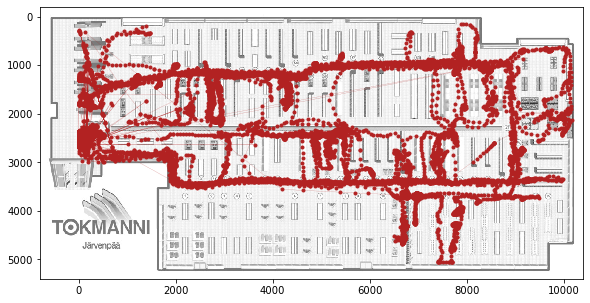

In [15]:
import matplotlib.pyplot as plt
img1 = plt.imread("pic.png")
fig, ax = plt.subplots()
#ax.imshow(img, extent=[0, 10406,  5220,0])
ax.imshow(img1, extent=[-800, 10400, 5400, -200])#ax.imshow(img)
#ax.plot(df.x, df.y , linewidth=2, color='firebrick')
df = df.drop(df[(df.x < 1850.0) & (df.y > 3000.0)].index)
ax.plot(df.x, df.y , marker='o', linestyle='dashed', linewidth=0.2, markersize=3, color='firebrick')
print(len(df.x))


In [16]:
prev = 0
val = 0
def calc_velocity(time_start, time_end):
    #diff_time = time_start - time_end
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 1
x = 0
for i in range(len(df.x)):
   # print(abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3])))
    #print(abs(df.index[i+1]) - abs(df.index[i]))
    if(i < len(df.x)):
        #print(i , " " , x, " ", len(df.x))
        value1 = calc_velocity(df.iloc[i-x, 1], df.iloc[i-(1+x), 1])
        value2 = int((abs(df.iloc[i-x, 2])) - prev)
        val =  value2 / value1
        if (val > 60 or value2 > 100):
            df.drop([df.index[i-x]], axis = 0, inplace = True)
            prev = abs(df.iloc[i-x, 2])
            x +=1
        else:
            prev = abs(df.iloc[i-x, 2])
x = 0
for i in range(len(df.y)):
   # print(abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3])))
    #print(abs(df.index[i+1]) - abs(df.index[i]))
    if(i < len(df.y)):
        value1 = calc_velocity(df.iloc[i-x, 1], df.iloc[i-(1+x), 1])
        value2 = int((abs(df.iloc[i-x, 3]))-prev)
        val = value2 / value1    
        if (val > 60 or value2 > 100):
            df.drop([df.index[i-x]], axis = 0)
            prev = abs(df.iloc[i-x , 3])
            x +=1
        else:
            prev = abs(df.iloc[i-x, 3])
    #print(prev)
    #if (abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3]))) > 400:
        #print("We int")
        
print(len(df.x))

125204


125204


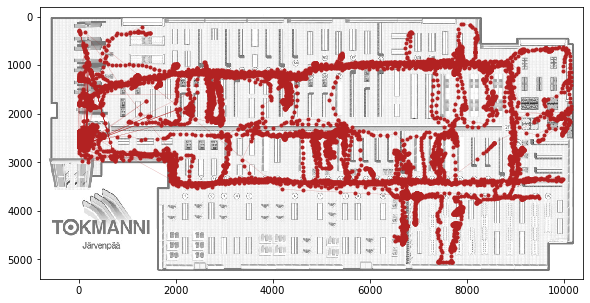

In [17]:
import matplotlib.pyplot as plt
img1 = plt.imread("pic.png")
fig, ax = plt.subplots()
#ax.imshow(img, extent=[0, 10406,  5220,0])
ax.imshow(img1, extent=[-800, 10400, 5400, -200])
#ax.imshow(img)
plt.rcParams['figure.figsize'] = 10, 5
#ax.plot(df.x, df.y , linewidth=1, color='firebrick')
ax.plot(df.x, df.y , marker='o', linestyle='dashed', linewidth=0.2, markersize=3, color='firebrick')
print(len(df.x))

In [18]:
#devx = [df.iloc[i + 1, 2] - df.iloc[i, 2] for i in range(len(df.x)-1)]
devx = []
for i in range(len(df.x)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 2]) - prev)) / value1
    #print(val)
    devx.append(val)
    prev = abs(df.iloc[i, 2])

xmean = np.mean(devx, axis=0)
xsd = np.std(devx, axis=0)
print(xmean)
print(xsd)
i = 0
final_list = [x for x in df.x if (abs(x) > xmean - 0.5 * xsd)]
#final_list = [x for x in final_list if (x < xmean + 0. * xsd)]
for x in final_list:
    if(x < xmean + 6.75 * xsd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
i = 0
#devy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)]
devy = []
for i in range(len(df.y)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 3]) - prev)) / value1
    #print(val)
    devy.append(val)
    prev = abs(df.iloc[i, 3])
ymean = np.mean(devy, axis=0)
ysd = np.std(devy, axis=0)
print(ymean)
print(ysd)
final_list1 = [y for y in df.y if (abs(y) > ymean - 0.5 * ysd)]
#final_list = [y for y in final_list if (y < ymean + 0.2 * ysd)]
i = 0
print(len(df.y))
for y in final_list1:
    if(y < ymean + 6.75 * ysd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
    

-0.05300518587314357
36.82141835497623
-1.7759582633161437
37.1738268598188
18788


18781


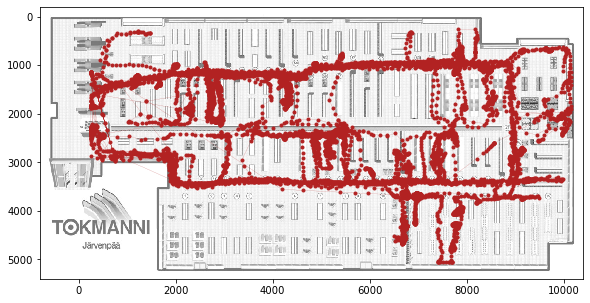

In [19]:
import matplotlib.pyplot as plt
img1 = plt.imread("pic.png")
fig, ax = plt.subplots()
#ax.imshow(img, extent=[-300, 10406,  5220,0])
ax.imshow(img1, extent=[-800, 10400, 5400, -200])#ax.imshow(img)
#ax.plot(df.x, df.y , linewidth=1, color='firebrick')
ax.plot(df.x, df.y , marker='o', linestyle='dashed', linewidth=0.2, markersize=3, color='firebrick')
print(len(df.x))

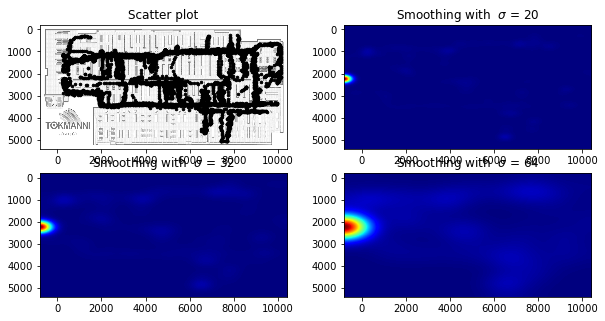

In [20]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[-1], xedges[0], yedges[-1], yedges[0]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x = df.x
y = df.y
sigmas = [0, 20, 32, 64]
for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.imshow(img1, extent=[-800, 10400, 5400, -200])
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        #ax.imshow(img1, extent=[-800, 10400, 5400, -200])#ax.imshow(img)
        ax.imshow(img, extent=[-800, 10400, 5400, -200], origin='upper', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

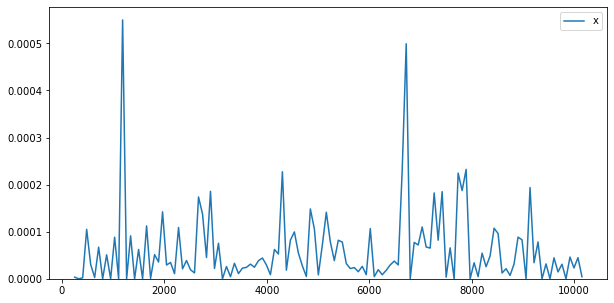

In [21]:
import seaborn as sns
ax = sns.kdeplot(x, bw=.15)

In [35]:
def calc_velocity1(time_start, time_end, ):
    #diff_time = time_start - time_end
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 1
x = 0
import math  
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist  
devx1 = []
time = []
dist = []
speed = []
i = 1
for i in range(len(df.x)):
    time.append(calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1]))
    #val = int((abs(df.iloc[i, 2]) - prev)) / value1
    dist.append(calculateDistance(abs(df.iloc[i, 2]), abs(df.iloc[i, 3]),abs(df.iloc[i-1, 2]),  abs(df.iloc[i-1, 3])))
    #print(val)
speed = []
for i in range(len(dist)):
    speed.append((dist[i] / 161)/time[i])
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
print(cal_average(speed))

0.1667751102800215


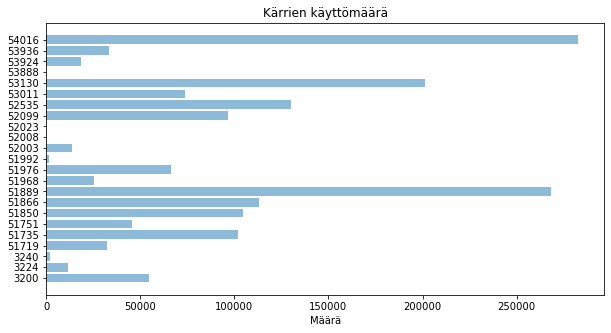

In [61]:
nodes = nodes.rename(columns={'COUNT(node_id)': 'amount'})
objects = nodes.node_id
y_pos = np.arange(len(objects))
performance = nodes.amount

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Määrä')
plt.title('Kärrien käyttömäärä')

plt.show()

In [94]:
#devx = [df.iloc[i + 1, 2] - df.iloc[i, 2] for i in range(len(df.x)-1)]
devx = []
for i in range(len(df.x)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 2]) - prev)) / value1
    #print(val)
    devx.append(abs(val))
    prev = abs(df.iloc[i, 2])

xmean = np.mean(devx, axis=0)
xsd = np.std(devx, axis=0)
print(xmean)
print(xsd)
i = 0
final_list = [x for x in df.x if (abs(x) > xmean - 0.5 * xsd)]
#final_list = [x for x in final_list if (x < xmean + 0. * xsd)]
for x in final_list:
    if(x < xmean + 0.001 * xsd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
i = 0
#devy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)]
devy = []
for i in range(len(df.y)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 3]) - prev)) / value1
    #print(val)
    devy.append(abs(val))
    prev = abs(df.iloc[i, 3])
ymean = np.mean(devy, axis=0)
ysd = np.std(devy, axis=0)
print(ymean)
print(ysd)
final_list1 = [y for y in df.y if (abs(y) > ymean - 0.5 * ysd)]
#final_list = [y for y in final_list if (y < ymean + 0.2 * ysd)]
i = 0
print(len(df.y))
for y in final_list1:
    if(y < ymean + 0.001 * ysd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
    

18.438485934258416
26.321612829249865
14.340906599159364
28.035859646405584
70818


In [ ]:
prevx = 0
#resy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)] 
devx = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.x)-1)]
#devx = statistics.stdev(df.x)
resx = [df.iloc[i + 1, 2] - df.iloc[i, 2] for i in range(len(df.x)-1)] 
i = 0
for cat,date,x,y,z,q in df.values:
    #print(abs(resx[i-1]))
    if(abs(resx[i-1]) < 1):
        df.drop([df.index[i-1]], axis = 0, inplace = True)
        i -= 1
    i += 1

prevy = 0
resy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)] 
i = 0

for cat,date,x,y,z,q in df.values:
    if(abs(resy[i-1]) < 1):
        df.drop([df.index[i-1]], axis = 0, inplace = True)
        i -= 1
    i += 1


In [ ]:
xmean = np.mean(df.x, axis=0)
xsd = np.std(df.x, axis=0)
ymean = np.mean(df.y, axis=0)
ysd = np.std(df.y, axis=0)

#final_list = [(int((x for x  in df.x if (x > xmean - 0.21 * xsd))), int((y for y in df.y if (y > ymean - 0.21 * ysd))))]
#final_list = [(x,y) for cat,date,x,y,z,q in df.values: if((x > xmean - 0.21 * xsd) and (y > ymean - 0.21 * ysd))]
final_list = []
for cat,date,x,y,z,q in df.values:
    if((x > xmean - 0.2 * xsd) or (y > ymean - 0.2 * ysd)):
        final_list.append([x,y])
print(len(final_list))
i = 0
for x, y in final_list:
    if((x < mean + 0.2 * sd) and (y < mean + 0.2 * sd)):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1

In [ ]:
resy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)] 
#resy = df.y['3']-df.y['2']
#resy = df.iloc[1,3] - df.iloc[0,3]
prevy = 0
for y in resy:
    #print(abs(y-prevy))
    #print(y)
    prevy = y
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg

print("The average is", cal_average(resy))
